In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Intro

- I ran lots of cases over the holiday. They were all without Tn=30eV
- They all sequentially enable boundary conditions without AFN, and then we have a case with everything on and AFN as well
- The AFN is old and unchained

# Hermes IO

In [2]:
db = CaseDB()
toload = [
    dict(name="all_afn", id = "d16hf-vthfix_neutpump_slpuff"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Looking for squash file
- Squash file found. squash date 09/25/2023, 15:48:49, dmp file date 09/13/2023, 21:23:54
CHECK: Total domain volume is 1.942E+00 [m3]


In [3]:
plt.close("all")
%matplotlib inline

## Calculating mean free path


$$l = \frac{1}{\sigma N}$$
$$ K = \sigma v_{rel}, \nu = K N $$
$$ \sigma = \frac{\nu}{Nv_{rel}} $$
$$ l = \frac{1}{N} \times \frac{Nv_{rel}}{\nu} = \frac{v_{rel}}{\nu}$$

In the perpendicular $v_{rel}$ can be $v_{th}^{i} + v_{th}^{n}$

In the parallel we have the relative velocity already

In [6]:
ds = casestore["all_afn"].ds

Ta = ds["Td"].values
Ti = ds["Td+"].values
Ne = ds["Ne"].values
Na = ds["Nd"].values
Vi = ds["Vd+"]
Va = ds["NVd"] / (ds["Nd"] * constants("mass_p")*2)

ln_sigmav = -18.5028
Teff = (Ta + Ti)/2
lnT = np.log(Teff)
lnT_n = lnT.copy()

for b in [0.3708409, 7.949876e-3, -6.143769e-4, -4.698969e-4, -4.096807e-4, 1.440382e-4, -1.514243e-5, 5.122435e-7]:
    ln_sigmav += b * lnT_n
    lnT_n *= lnT
    
nu_cx = np.exp(ln_sigmav) * 1e-6 * Ne # convert from cm^3/s to m^3/s
nu = nu_cx  # Only consider CX for now
v_thi = np.sqrt((ds["Td+"]*constants("q_e")) / (constants("mass_p")*2))
v_thn = np.sqrt((ds["Td"]*constants("q_e")) / (constants("mass_p")*2))

Vi_pol = Vi / (ds["J"] / np.sqrt(ds["g_22"]))
Va_pol = Va / (ds["J"] / np.sqrt(ds["g_22"]))

# From Meier, eqn (17)
v_cx = np.sqrt(4/np.pi * v_thi**2 + 4/np.pi * v_thn**2 + np.abs(Vi_pol - Va_pol)**2)

L_T_rad = 1 / (ds["Td+"].bout.ddx() / ds["Td+"])
L_T_pol = 1 / (ds["Td+"].bout.ddy() / ds["Td+"])

mfp = v_cx / nu


Kn_rad = abs(mfp / L_T_rad)
Kn_pol = abs(mfp / L_T_pol)

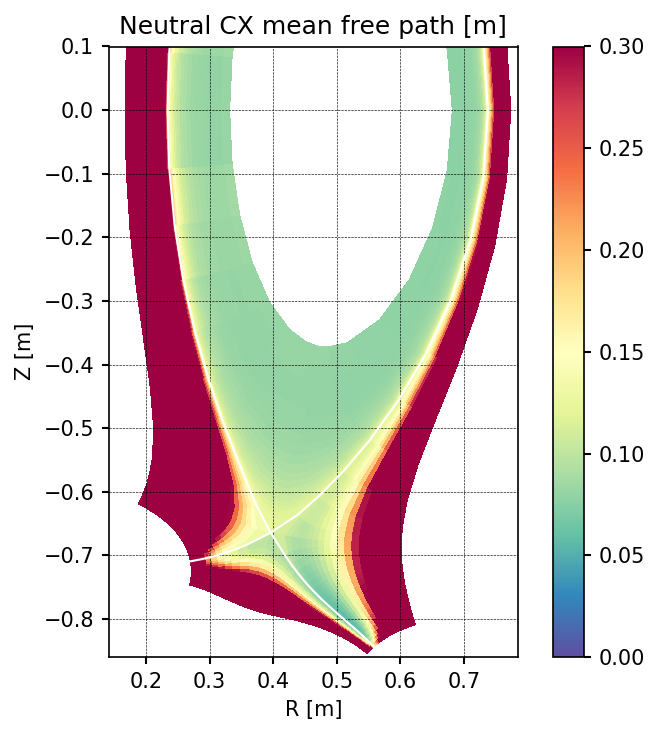

In [5]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
mfp.hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", vmin = 0, vmax = 0.3, logscale = False, add_colorbar = True)
ax.set_title("Neutral CX mean free path [m]")

fig.tight_layout()
ax.set_ylim(-0.86, 0.1)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.grid(alpha = 1, c = "k", ls = "--")

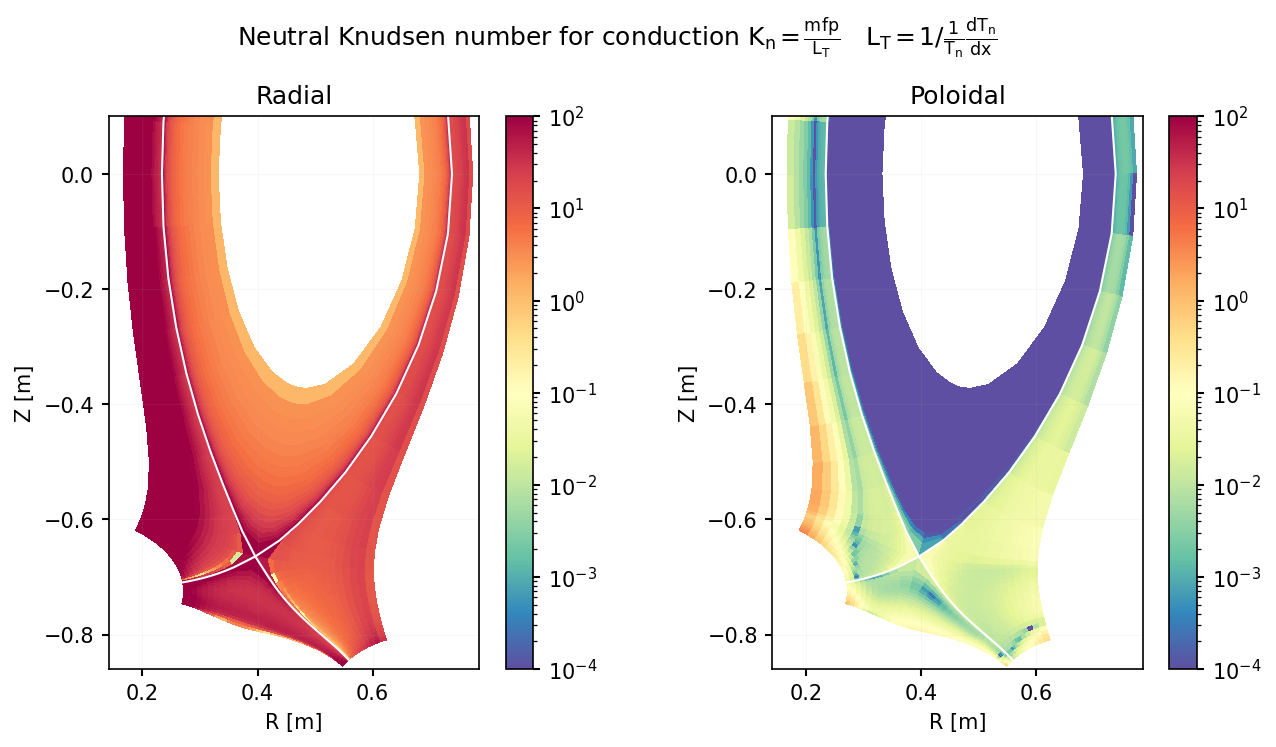

In [9]:
fig, axes = plt.subplots(1,2, figsize = (9,5), dpi = 150)
Kn_rad.hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", vmin = 1e-4, vmax = 100, logscale = True, add_colorbar = True)
axes[0].set_title(r"Radial")
Kn_pol.hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", vmin = 1e-4, vmax = 100, logscale = True, add_colorbar = True)
axes[1].set_title(r"Poloidal")
fig.suptitle(r"Neutral Knudsen number for conduction $K_{n} = \frac{mfp}{L_{T}}$   $L_{T} = 1 / \frac{1}{T_{n}} \frac{dT_{n}}{dx}$")


for ax in axes:
    ax.set_ylim(-0.86, 0.1)
    
fig.tight_layout()


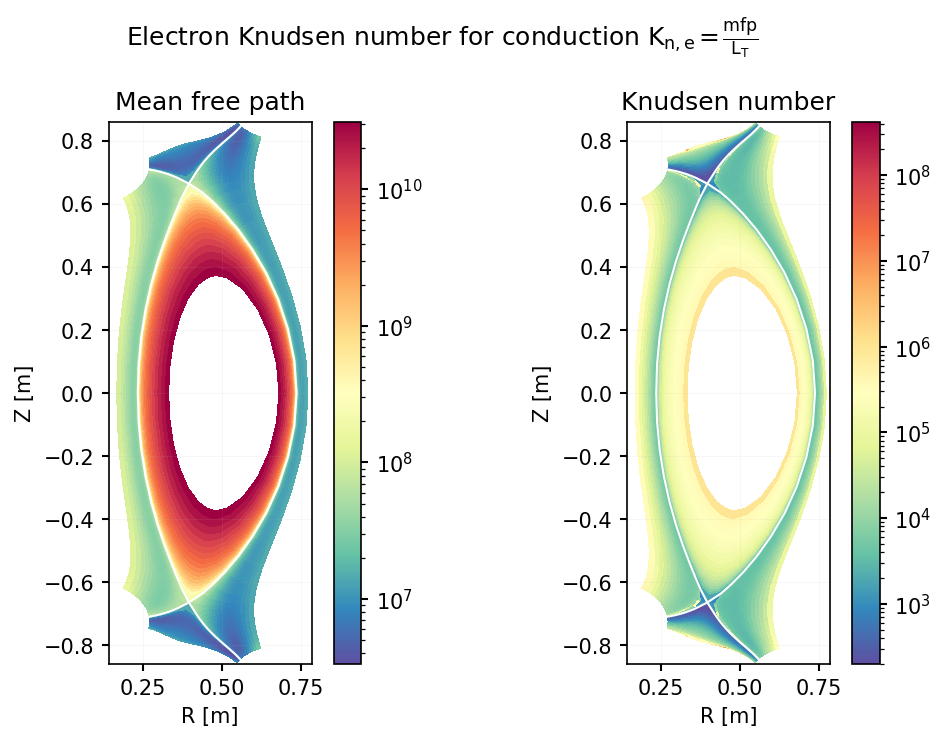

In [ ]:
v_the = np.sqrt((ds["Te"]*constants("q_e")) / (constants("mass_e")))
mfp_e = v_the / (ds["Kee_coll"] + ds["Ked+_coll"])
Kn_e = mfp_e / np.sqrt(abs(L_T_rad)**2 + abs(L_T_pol)**2)

fig, axes = plt.subplots(1,2, figsize = (7,5), dpi = 150)

mfp_e.hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", vmin = None, vmax = None, logscale = True, add_colorbar = True)
axes[0].set_title(r"Mean free path")

Kn_e.hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", vmin = None, vmax = None, logscale = True, add_colorbar = True)
axes[1].set_title(r"Knudsen number")
fig.suptitle(r"Electron Knudsen number for conduction $K_{n,e} = \frac{mfp}{L_{T}}$")
fig.tight_layout()


In [6]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [7]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

all_afn
all
nopump
nofrec
norefl
noedgerec
nodecaylength
noescapecore


# Read SOLEDGE CSV data

In [8]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [9]:
solpscases = {
    "base" : os.path.join(onedrive_path,           r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path,      r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path,     r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path,     r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path,     r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,      r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path,      r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path,    r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path,        r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [10]:
for name in casestore:

    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds)



# Lineplots

In [11]:
plt.close("all")
%matplotlib inline

## Heat balance

In [98]:
ds = casestore["all_afn"].ds.isel(t=-1)

if ds["t"].shape != ():
    raise Exception("Please supply a single time slice")
places = {}

places["inner_wall  "] = ds.hermesm.select_region("inner_sol_edge")
places["outer_wall  "] = ds.hermesm.select_region("outer_sol_edge")
places["pfr         "] = ds.hermesm.select_region("pfr_edge")

if "Ed_wall_refl" in ds.data_vars:
    hflows = {}
    for place in places:
        ds_place = places[place]
        hflows[place] = ()
        hflows[place] = (ds_place["Ed_wall_refl"] * ds_place["dv"] ).sum().values * 1e-6
        
    hflows["targets     "] = (ds["Ed_target_refl"] * ds["dv"]).sum().values * 1e-6
    
    print("Wall reflective cooling:")
    tot = 0
    for name in hflows:
        print(f"{name}: {hflows[name]:.3f} [MW]")
        tot += hflows[name]
        
    print(f"Total       : {tot:.3f} [MW]\n")
    
print("Recycling neutral energy source:")
en_rec = (ds["Ed_target_recycle"] * ds["dv"]).sum(["x", "theta"]).values * 1e-6
print(f"Total       : {en_rec:.3f} [MW]")

Wall reflective cooling:
inner_wall  : -0.015 [MW]
outer_wall  : -0.128 [MW]
pfr         : -0.082 [MW]
targets     : -0.030 [MW]
Total       : -0.254 [MW]

Recycling neutral energy source:
Total       : 0.221 [MW]


# Impact of fast reflection

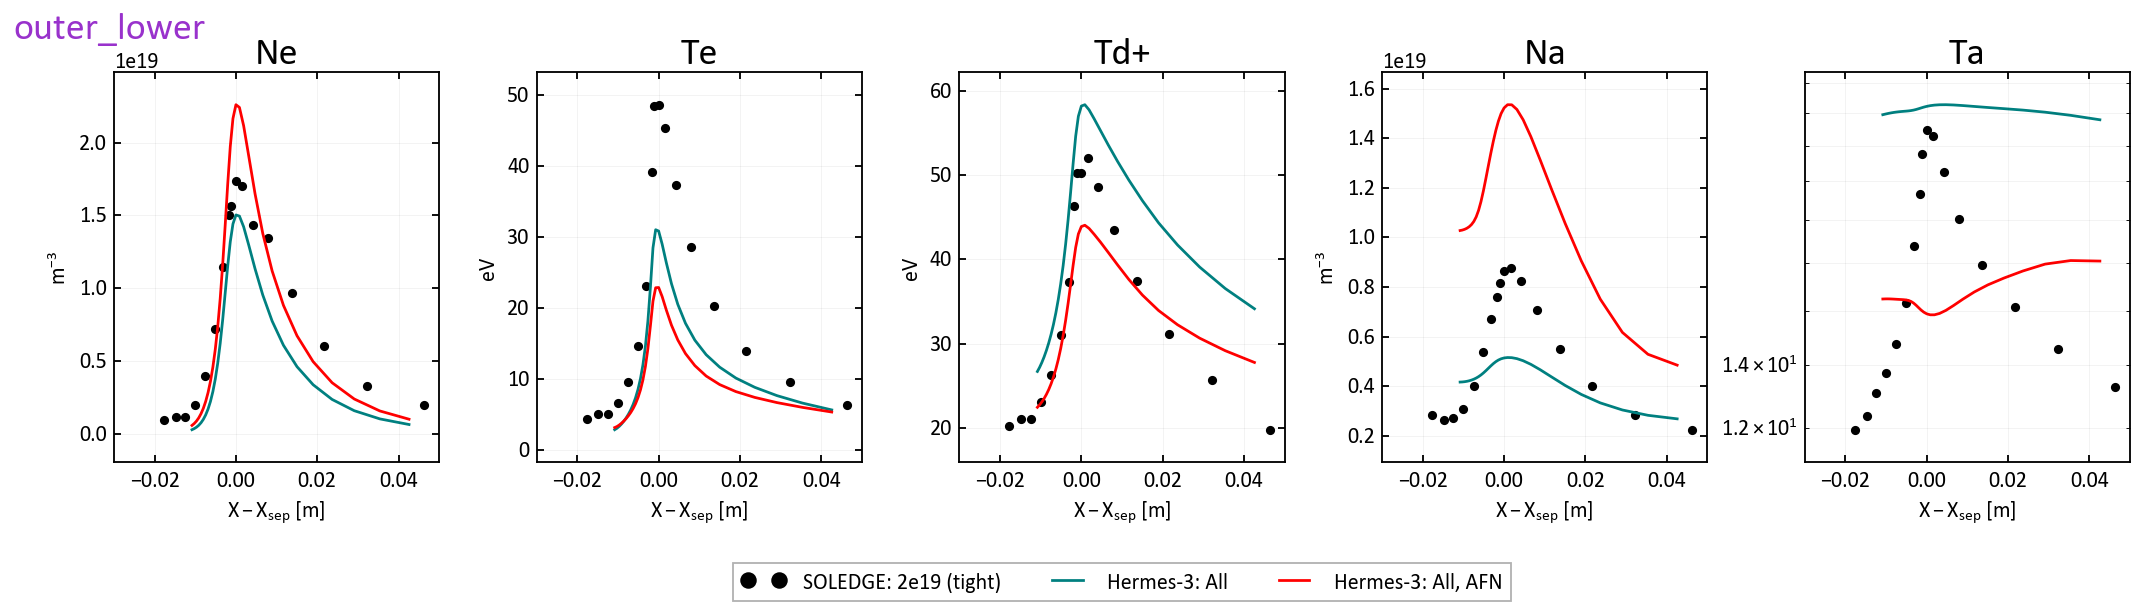

In [96]:

plt.close("all")
lineplot_compare(
    cases = { 

    # "Hermes-3: Fast recycling": dict(data=hr["fastrec"], color = "red"),
    
    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    # "Hermes-3: Base": dict(data=hr["noescapecore"], color = "teal"),

    # "Hermes-3: Reflcool, esccore, edgerec": dict(data=hr["nofrec"], color = "darkorange"),
    
    # "Hermes-3: Fast recycling": dict(data=hr["nopump"], color = "firebrick"),
    # "Hermes-3: Pump": dict(data=hr["all"], color = "mediumblue"),
    
    "Hermes-3: All": dict(data=hr["all"], color = "teal"),
    "Hermes-3: All, AFN" : dict(data=hr["all_afn"], color = "red"),
    
    
    # "SOLEDGE: 2e19" : dict(data=sl["widewall_2e19"], color = "red")
    # "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="black"),
    },
    # regions = ["omp", "imp", "outer_lower", "outer_upper"], 
    regions = ["outer_lower"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    mode = "log",
    dpi = 120,
    lw = 2
)

In [95]:
%matplotlib inline

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


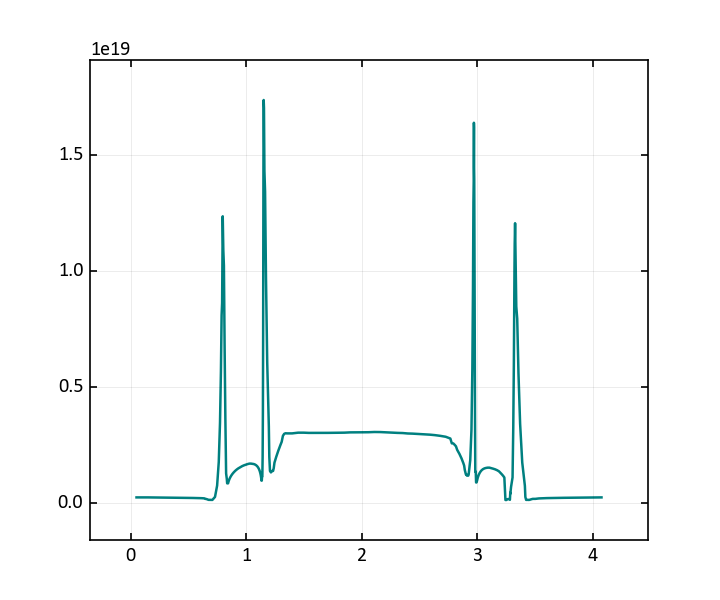

In [93]:
plt.close("all")
slc = SOLEDGEcase(soledgecases["tightwall_2e19"])
df = slc.get_wall_ntmpi()

plt.plot(df["L"], df["Ne"])

### Conductive SOL heat balance

In [12]:

ds = casestore["fixes"].ds.isel(t=-1)
ds = calculate_radial_fluxes(ds)
hflows = {}


hflows["outer_sol"] = ds.hermesm.select_region("outer_sol_edge")["hf_perp_tot_R_d"].sum("theta").values * 1e-6
hflows["inner_sol"] = ds.hermesm.select_region("inner_sol_edge")["hf_perp_tot_L_d"].sum("theta").values * 1e-6
hflows["lower_pfr_edge"] = ds.hermesm.select_region("lower_pfr_edge")["hf_perp_tot_L_d"].sum("theta").values * 1e-6
hflows["upper_pfr_edge"] = ds.hermesm.select_region("upper_pfr_edge")["hf_perp_tot_L_d"].sum("theta").values * 1e-6
# plot_selection(ds, ds.hermesm.select_region("outer_sol_edge"))

tot = 0
for name in hflows:
    print(f"{name}: {hflows[name][0]:.3f}")
    tot += hflows[name]
    
print(f"Total: {tot[0]:.3f}")

outer_sol: 0.000
inner_sol: 0.009
lower_pfr_edge: 0.000
upper_pfr_edge: 0.000
Total: 0.009


In [34]:
hflows[name]

array([0.10038744])

### Reflective neutrals balance

In [34]:
hr.keys()

dict_keys(['escapecore', 'condsol', 'neutralbc', 'gamma0.4', 'halfcond', 'pump', 'fixes'])

In [18]:
ds = casestore["fixes"].ds.isel(t=-1)
places = {}
places["outer_wall"] = ds.hermesm.select_region("outer_sol_edge")
places["inner_wall"] = ds.hermesm.select_region("inner_sol_edge")
places["pfr"] = ds.hermesm.select_region("pfr_edge")

hflows = {}
for place in places:
    ds_place = places[place]
    hflows[place] = ()
    hflows[place] = (ds_place["Ed_wall_refl"] * ds_place["dv"] ).sum().values * 1e-6
    
hflows["targets"] = (ds["Ed_target_refl"] * ds["dv"]).sum().values * 1e-6

In [19]:
tot = 0
for name in hflows:
    print(f"{name}: {hflows[name]:.3f}")
    tot += hflows[name]
    
print(f"Total: {tot:.3f}")

outer_wall: -0.138
inner_wall: -0.014
pfr: -0.069
targets: -0.031
Total: -0.252


In [72]:
for case in casestore:
    print(f">>>>{case}")
    calculate_simple_heat_balance(casestore[case].ds.isel(t=-1))


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
>>>>all_afn
outer_wall: -0.128
inner_wall: -0.015
pfr: -0.082
targets: -0.030
Total: -0.254

>>>>all
outer_wall: -0.108
inner_wall: -0.011
pfr: -0.075
targets: -0.025
Total: -0.218

>>>>nopump
outer_wall: -0.113
inner_wall: -0.011
pfr: -0.076
targets: -0.024
Total: -0.224

>>>>nofrec
outer_wall: -0.092
inner_wall: -0.009
pfr: -0.049
targets: -0.016
Total: -0.166

>>>>norefl
outer_wall: 0.000
inner_wall: 0.000
pfr: 0.000
targets: 0.000
Total: 0.000

>>>>noedgerec
outer_wall: 0.000
inner_wall: 0.000
pfr: 0.000
targets: 0.000
Total: 0.000

>>>>nodecaylength
outer_wall: 0.000
inner_wall: 0.000
pfr: 0.000
targets: 0.000
Total: 0.000

>>>>noescapecore
outer_wall: 0.000
inner_wall: 0.000
pfr: 0.000
targets: 0.000
Total: 0.000



In [19]:
plt.close("all")
%matplotlib inline

In [99]:
for case in casestore:
    casestore[case].ds = calculate_radial_fluxes(casestore[case].ds)

# Transport

In [103]:
casestore.keys()

dict_keys(['all_afn', 'all', 'nopump', 'nofrec', 'norefl', 'noedgerec', 'nodecaylength', 'noescapecore'])

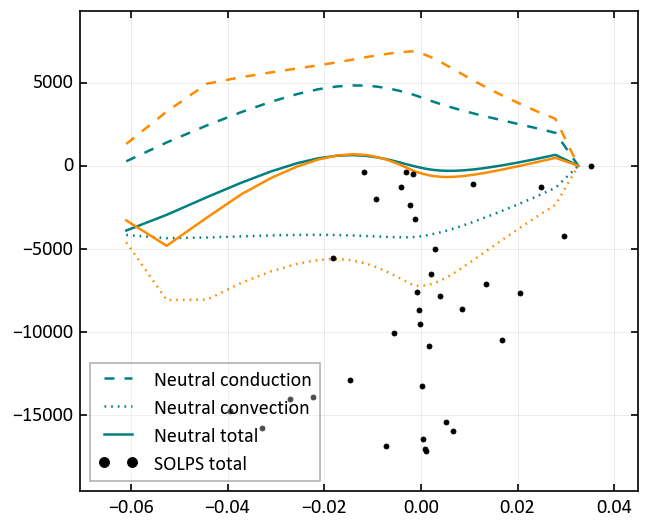

In [119]:




m = "x"
ms = 0
scale = 1

fig, ax = plt.subplots()

colors = ["teal", "darkorange"]
for i, casename in enumerate(["all", "all_afn"]):
    ds = casestore[casename].ds.isel(t=-1)
    d = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    dist = np.insert(dist.values, 0, dist.values[0] - (dist.values[1] - dist.values[0]))

    def append_rhs(x):
        F = d[x].values
        rhs = d[x.replace("_L_", "_R_")][-1].values
        return np.concatenate([F, [rhs]])

    if i == 0:
        ax.plot(dist, append_rhs("hf_perp_diff_L_d")*scale, label = "Neutral conduction", marker = m, ls = "--", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_conv_L_d")*scale, label = "Neutral convection", marker = m, ls = ":", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_tot_L_d")*scale, label = "Neutral total", marker = m, ls = "-", ms = ms, c = colors[i])
    else:
        ax.plot(dist, append_rhs("hf_perp_diff_L_d")*scale, marker = m, ls = "--", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_conv_L_d")*scale, marker = m, ls = ":", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_tot_L_d")*scale, marker = m, ls = "-", ms = ms, c = colors[i])
        
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS total", color = "black", lw=0, marker = "o", ms = 3,)
ax.legend()

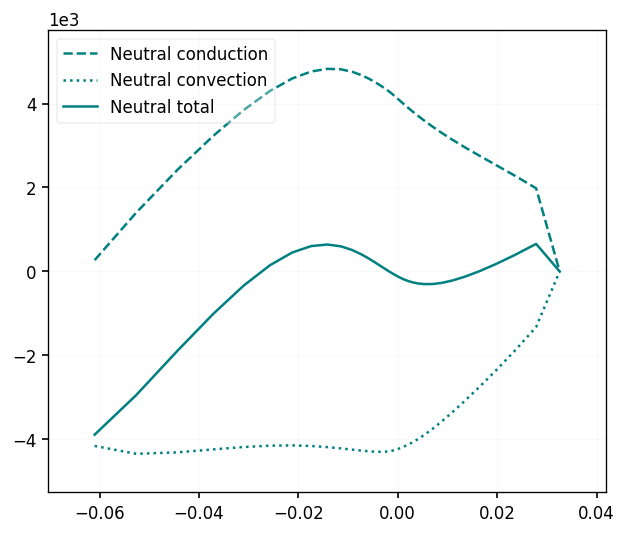

In [95]:




m = "x"
ms = 0
scale = 1

fig, ax = plt.subplots()

colors = ["teal", "darkorange"]
for i, casename in enumerate(["all"]):
    ds = casestore[casename].ds.isel(t=-1)
    d = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    dist = np.insert(dist.values, 0, dist.values[0] - (dist.values[1] - dist.values[0]))

    def append_rhs(x):
        F = d[x].values
        rhs = d[x.replace("_L_", "_R_")][-1].values
        return np.concatenate([F, [rhs]])

    if i == 0:
        ax.plot(dist, append_rhs("hf_perp_diff_L_d")*scale, label = "Neutral conduction", marker = m, ls = "--", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_conv_L_d")*scale, label = "Neutral convection", marker = m, ls = ":", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_tot_L_d")*scale, label = "Neutral total", marker = m, ls = "-", ms = ms, c = colors[i])
    else:
        ax.plot(dist, append_rhs("hf_perp_diff_L_d")*scale, marker = m, ls = "--", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_conv_L_d")*scale, marker = m, ls = ":", ms = ms, c = colors[i])
        ax.plot(dist, append_rhs("hf_perp_tot_L_d")*scale, marker = m, ls = "-", ms = ms, c = colors[i])
        
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS total", color = "black", lw=0, marker = "o", ms = 3,)
ax.legend()

Text(0.5, 1.0, '')

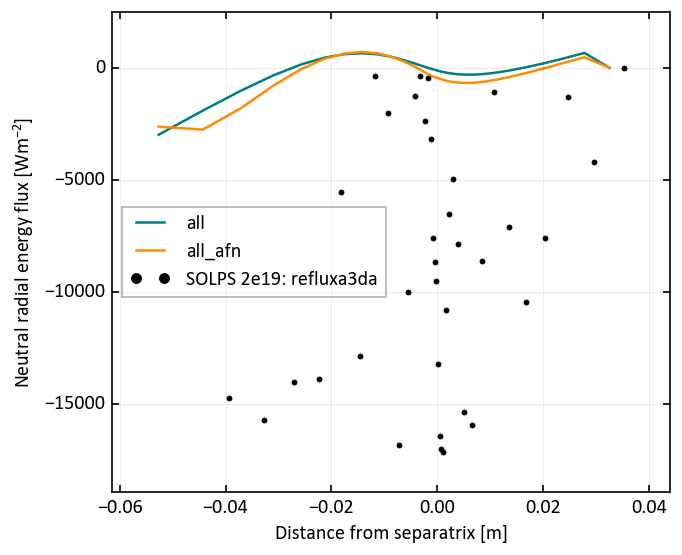

In [117]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn", "halfcond"]
labels = ["Standard", "AFN, no MFP limit"]
for i, case in enumerate(["all", "all_afn"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = case)


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3,)
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")

## Nd

In [50]:
%matplotlib inline

In [49]:
import sdtools.general.plotstyle

SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


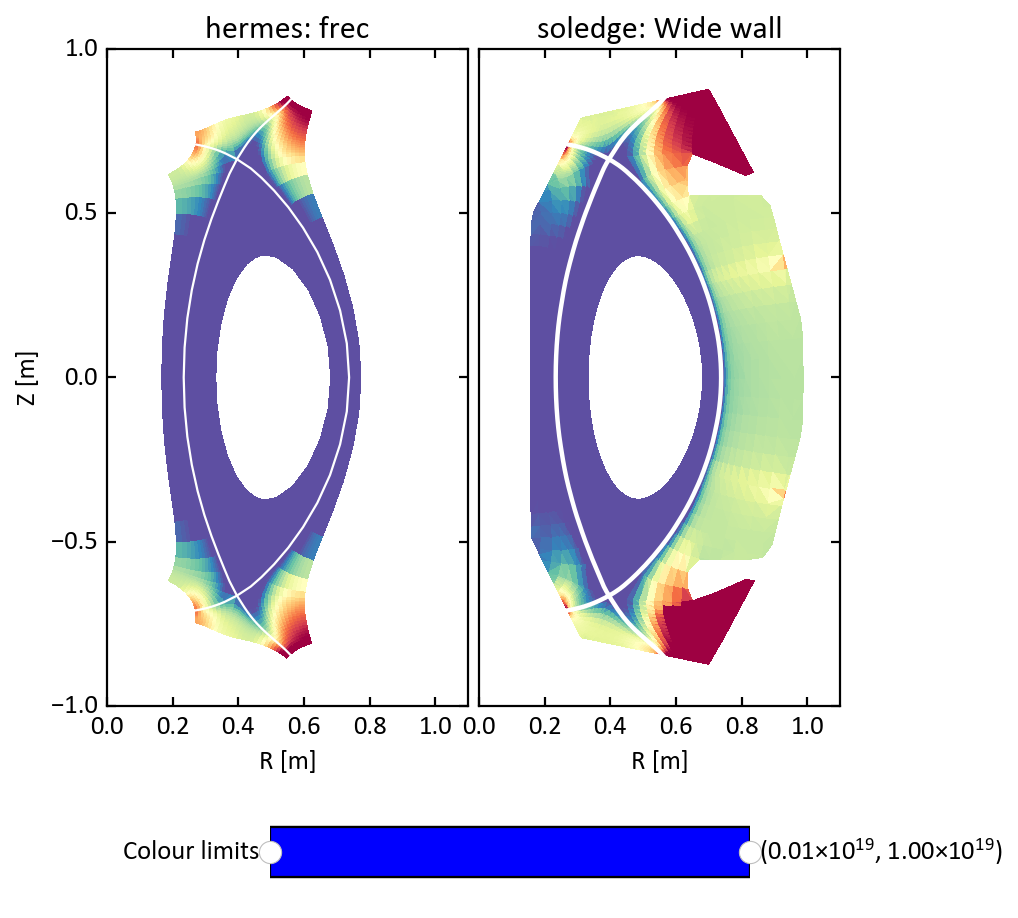

In [56]:
v = viewer_2d(
    "Nd",
    [
        {"name" : "frec", "code" : "hermes", "ds" : casestore["fastrec"].ds.isel(t=-1)},
        # {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = True,
    # vmin = 0,
    # vmax = 60,
    vmin = 1e17,
    vmax = 1e19,
    dpi = 160,
    ylim = (-1,1), #(-0.9,0.9),
    xlim = (0, 1.1), #(0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r",
    add_cbar = False
)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


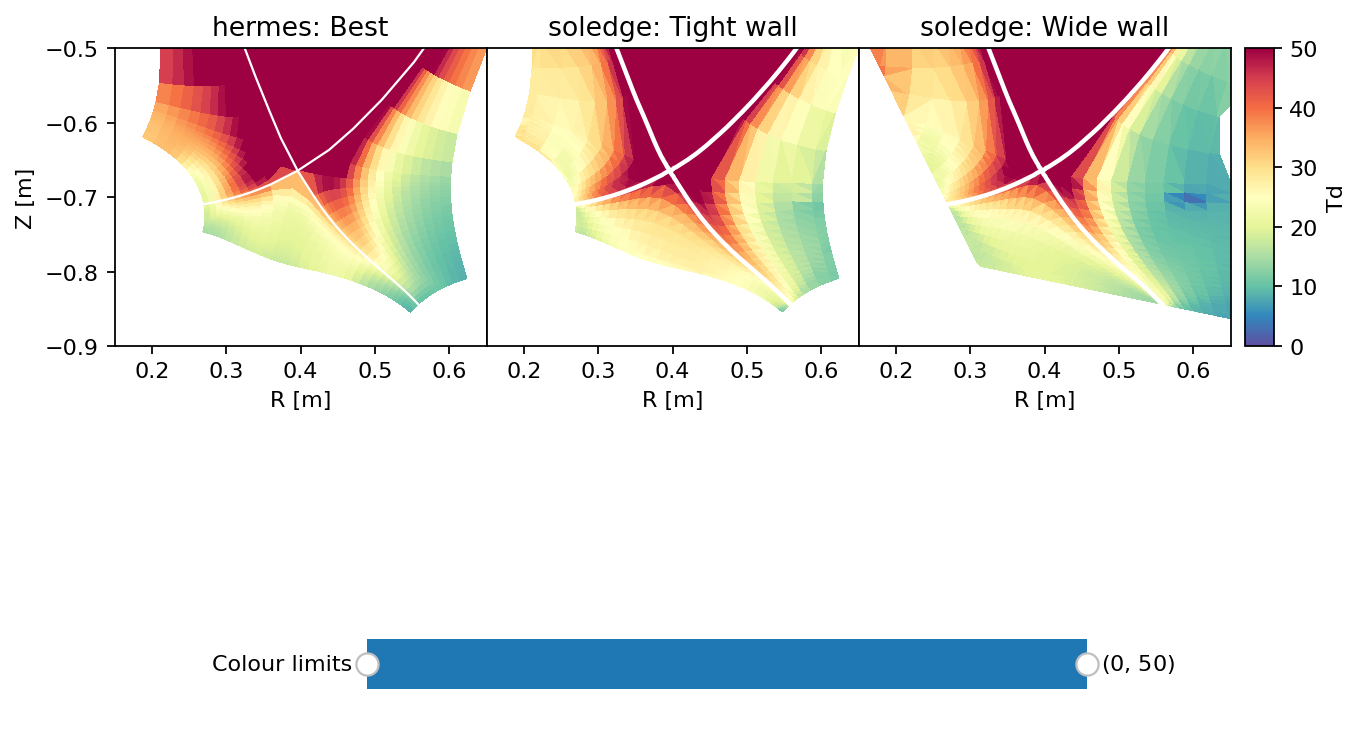

In [18]:
plt.close("all")
v = viewer_2d(
    "Td",
    [
        # {"name" : "Best", "code" : "hermes", "ds" : casestore["base"].ds.isel(t=-1)},
        {"name" : "Best", "code" : "hermes", "ds" : casestore["fastrec"].ds.isel(t=-1)},
        {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = False,
    vmin = 0,
    vmax = 50,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,-0.5),
    xlim = (0.15, 0.65),
    wspace = 0.0,
    cmap = "Spectral_r"
)

SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


SOLEDGE: Combining Nmi and Nni


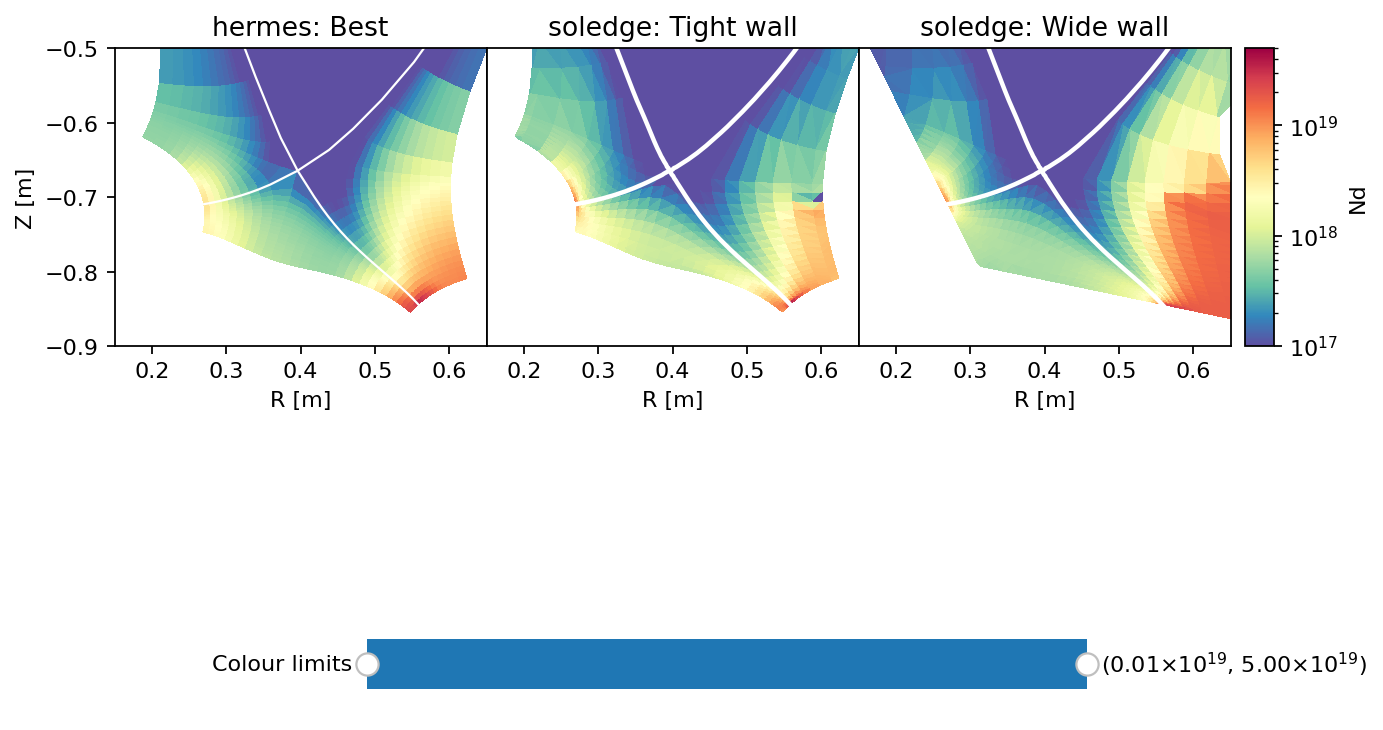

In [23]:
plt.close("all")
v = viewer_2d(
    "Nd",
    [
        # {"name" : "Best", "code" : "hermes", "ds" : casestore["base"].ds.isel(t=-1)},
        {"name" : "Best", "code" : "hermes", "ds" : casestore["fastrec"].ds.isel(t=-1)},
        {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = True,
    # vmin = 0,
    # vmax = 50,
    vmin = 1e17,
    vmax = 5e19,
    dpi = 160,
    ylim = (-0.9,-0.5),
    xlim = (0.15, 0.65),
    wspace = 0.0,
    cmap = "Spectral_r"
)

# Poloidal plot dev

In [ ]:
from code_comparison.solps_pp import *
params = ["Ne"]


self = SOLPScase(solpscases["nsep_2e19"])

region = "outer"
dist_from_sep = 0.001

if "outer" in region:
    radial_locator = self.s["omp"]
elif "inner" in region:
    radial_locator = self.s["imp"]
else:
    raise Exception(f"Region {region} not recognised")

p = radial_locator
radial_dist = self.g["R"][p[0], p[1]] - self.g["R"][p[0], self.g["sep"]] 
ring_index = np.argmin(abs(dist_from_sep - radial_dist))
ring_from_sep = ring_index - self.g["sep"]
print(f"Distance {dist_from_sep} corresponds to SOL ring {ring_from_sep}")    

# Get slice of the separatrix for the requested region
p = self.s[region]
p[1] += ring_from_sep   # Advance to desired SOL ring

poloidal_dist = 

dpi = 150
fig, axes = plt.subplots(2,len(params), dpi = dpi, figsize = (4.2*len(params),5), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.25, bottom = 0.25, left = 0.1, right = 0.9)

ax = axes[0]
ax.plot(dist, self.bal["ne"][:][p[0], p[1]])

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


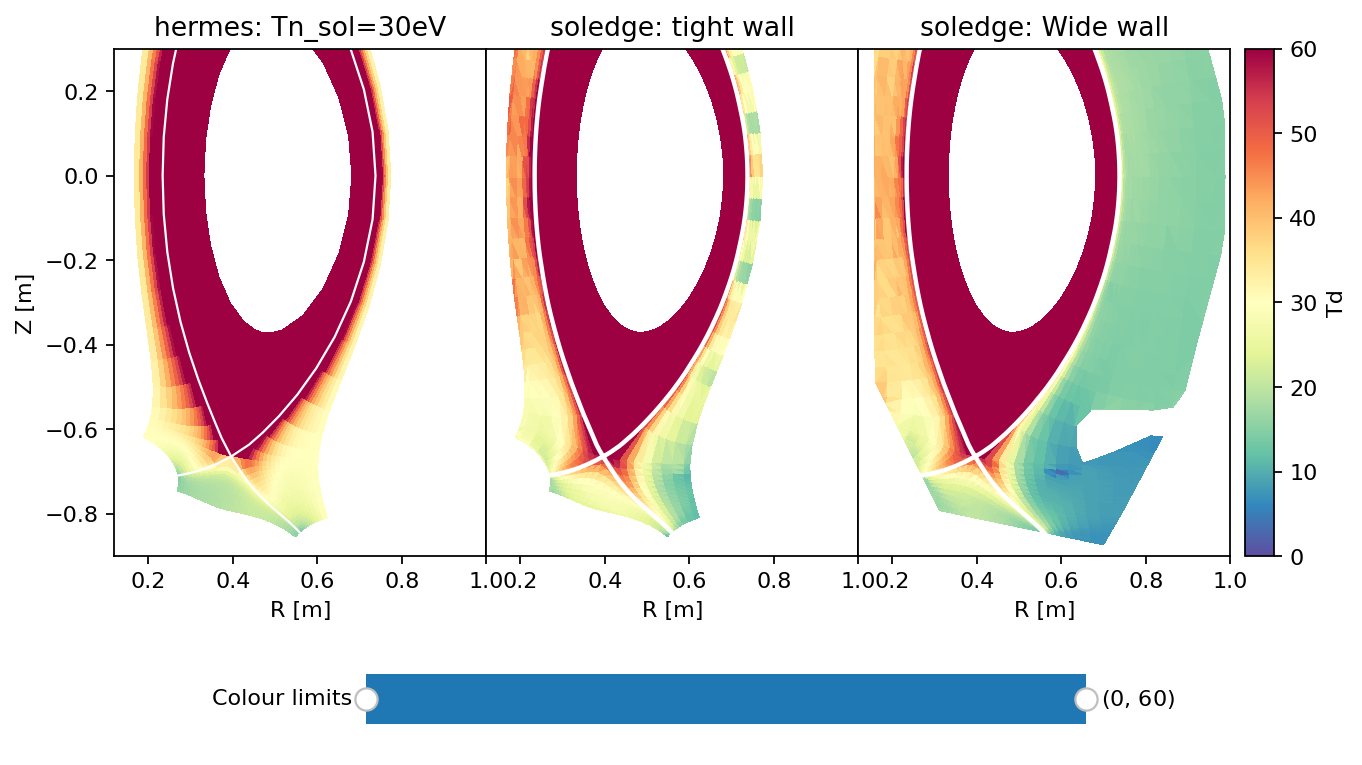

In [31]:
v = viewer_2d(
    "Td",
    [
        {"name" : "Tn_sol=30eV", "code" : "hermes", "ds" : casestore["2e19"].ds.isel(t=-1)},
        {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name": "Wide wall", "code":"soledge", "path" : soledgecases["widewall_2e19"]}
    ],
    logscale = False,
    vmin = 0,
    vmax = 60,
    # vmin = 1e16,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)